## <u> Explanatory Data Analysis </u>

The aim of this notebook is to provide a concise overview of the data dimensions relevant to the target variable. More specifically the focus is zoomed on how individual features relate to the probability of default. While this analysis is not exhaustive and more advanced visualizations are presented in the dashboard, this notebook builds initial insights to guide later feature selection and feature engineering. The data used are the result of the preprocessing steps finalized in SQL and are available under the `01_data_preprocessing_SQL` folder for reference.

### <u> 1. Setup</u>


In [1]:
# Import libraries
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys


# Set root directory for module imports
sys.path.append('..')

# Import modules
from modules.modules_eda import *


In [2]:
# Import dataset and column descriptions
home_credit = pd.read_csv('../data/processed/home_credit_cleaned.csv', index_col = 0)
columns_info = pd.read_csv('../data/processed/columns_info.csv')
print(f'Shape of the dataset: {home_credit.shape}')

Shape of the dataset: (307511, 100)


### <u> 2. Data Overview</u>


In [3]:
home_credit.head(3)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,...,prev_cnt_xna_unused,AMT_REQ_CREDIT_BUREAU_flag_na,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OCCUPATION_TYPE,OWN_CAR_AGE
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
149977,0,Cash loans,M,0,180000.0,1288350.0,37800.0,1125000.0,Unaccompanied,Working,...,0,0,0,0,0,0,0,0,Laborers,13.0
149261,1,Cash loans,F,1,225000.0,539100.0,27652.5,450000.0,"Spouse, partner",Working,...,0,0,0,0,0,0,3,5,Private service staff,NaN
451117,0,Cash loans,F,2,103500.0,101880.0,11101.5,90000.0,Unaccompanied,Working,...,0,1,0,0,0,0,0,0,Laborers,NaN


Based on early exploration via BigQuery SQL, the dataset contains 100 features subdivised as follow:

- Target: Binary default indicator (`TARGET`)
- Binary flags: Ownership, regional mismatches, contact info, documents, credit history (37 variables)
- Standardized scores: External data sources and regional metrics (0-1 scalce) (4 variables)
- Continuous features: Loan amounts, income, age, employment duration, family, and previous loan history (48 variables)
- Categorical features: Demographics (gender, education, occupation, family status, housing, contract type) (10 variables)


In [4]:
# ID column 
id_column = 'SK_ID_CURR'

# Target variable
target_variable = 'TARGET'

# Binary variables (0/1 flags)
binary_variables = [
    # Contact flags
    'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL',
    # Geographic mismatch flags
    'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY',
    # Document flags
    'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
    # Ownership and history flags
    'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'bur_has_history', 'prev_has_history', 'AMT_REQ_CREDIT_BUREAU_flag_na'
]

# Standardized variables (0-1 normalized scale)
standardized_variables = [
    'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_POPULATION_RELATIVE'
]

# Categorical variables (nominal and ordinal)
categorical_variables = [
    'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
    'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'
]

# Continuous variables
continuous_variables = [
    # Loan and income
    'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL',
    # Family/household
    'CNT_CHILDREN', 'CNT_FAM_MEMBERS',
    # Time-based features
    'YEARS_BIRTH', 'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_REGISTRATION', 
    'YEARS_LAST_PHONE_CHANGE', 'HOUR_APPR_PROCESS_START',
    # Region ratings
    'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
    # Social circle observations
    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
    # Bureau credit history aggregates
    'bur_cnt_closed', 'bur_cnt_active', 'bur_cnt_sold', 'bur_bad_debt_count', 
    'bur_sum_max_overdue', 'bur_max_single_overdue', 'bur_sum_debt',
    # Previous application counts
    'prev_cnt_cash_approved', 'prev_cnt_cash_refused', 'prev_cnt_cash_canceled', 'prev_cnt_cash_unused',
    'prev_cnt_revolving_approved', 'prev_cnt_revolving_refused', 'prev_cnt_revolving_canceled', 'prev_cnt_revolving_unused',
    'prev_cnt_consumer_approved', 'prev_cnt_consumer_refused', 'prev_cnt_consumer_canceled', 'prev_cnt_consumer_unused',
    'prev_cnt_xna_approved', 'prev_cnt_xna_refused', 'prev_cnt_xna_canceled', 'prev_cnt_xna_unused',
    # Credit bureau inquiries
    'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',
    # Car age
    'OWN_CAR_AGE'
]


#### <u>**2.1 Binary Variables**</u>

In [5]:
# Missing values analysis for binary variables
missing_df_binary = eda(home_credit, binary_variables, order_asc = False)
missing_df_binary.head(3)

,Variable,Missing_Count,Missing_Percentage
0,FLAG_MOBIL,0,0.0
19,FLAG_DOCUMENT_9,0,0.0
21,FLAG_DOCUMENT_11,0,0.0


In [6]:
# Check binary variables count
if ((home_credit[binary_variables].nunique() == 2).all() and
min(home_credit[binary_variables].min()) == 0 
and max(home_credit[binary_variables].max()) == 1):
    print('All binary variables are correctly encoded as 0/1 flags.')
else:
    print('Some binary variables are not correctly encoded as 0/1 flags.')

All binary variables are correctly encoded as 0/1 flags.


#### <u>**2.2 Standardized Variables**</u>

In [7]:
# Missing values analysis for standardized variables
missing_df_standardized = eda(home_credit, standardized_variables, order_asc = False)
missing_df_standardized.head(5)

,Variable,Missing_Count,Missing_Percentage
0,EXT_SOURCE_1,173378,56.38
2,EXT_SOURCE_3,60965,19.83
1,EXT_SOURCE_2,660,0.21
3,REGION_POPULATION_RELATIVE,0,0.00


In [8]:
# Check if standardized variables are within 0-1 range NaN excluded
if ((home_credit[standardized_variables].dropna() >= 0).all().all() and
    (home_credit[standardized_variables].dropna() <= 1).all().all()):
    print('All standardized variables are within the 0-1 range.')
else:
    print('Some standardized variables are outside the 0-1 range.')

All standardized variables are within the 0-1 range.


<u>Comment:</u>

Compared to the binary variables, higher levels of missing values are present in this subset of features. During variable selection, careful attention will be paid to evaluating their predictive value, especially for `EXT_SOURCE_1` which is available for less than half of the applicants.

#### <u>**2.3 Categorical Variables**</u>

In [9]:
missing_df_categorical = eda(home_credit, categorical_variables, categorical = True, order_asc = False)
missing_df_categorical.head(12)

,Variable,Missing_Count,Missing_Percentage,Distinct_Values_Count
2,NAME_TYPE_SUITE,1292,0.42,7
8,ORGANIZATION_TYPE,0,0.00,58
7,OCCUPATION_TYPE,0,0.00,19
3,NAME_INCOME_TYPE,0,0.00,8
9,WEEKDAY_APPR_PROCESS_START,0,0.00,7
5,NAME_FAMILY_STATUS,0,0.00,6
6,NAME_HOUSING_TYPE,0,0.00,6
4,NAME_EDUCATION_TYPE,0,0.00,5
1,CODE_GENDER,0,0.00,3
0,NAME_CONTRACT_TYPE,0,0.00,2


In [10]:
# Different values count for the categorical variable
home_credit['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

<u>Comment:</u>

All categorical variables are complete with no missing values except `NAME_TYPE_SUITE` (0.42% missing), which defines the person accompanying the borrower during application. Given the small tail categories (Other_B, Other_A, Group of people) and missing values, these could be merged into a single "Other" category during feature engineering if this variable passes feature selection.

#### <u>**2.4 Continuous Variables**</u>

In [11]:
# Basic statistics over continuous variables
home_credit[continuous_variables].describe(percentiles=[]).round(2)

,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,AMT_INCOME_TOTAL,CNT_CHILDREN,CNT_FAM_MEMBERS,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_ID_PUBLISH,YEARS_REGISTRATION,...,prev_cnt_xna_refused,prev_cnt_xna_canceled,prev_cnt_xna_unused,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OWN_CAR_AGE
count,307511.00,307499.00,307233.00,3.075110e+05,307511.00,307509.00,307511.00,252137.00,307511.00,307511.00,...,307511.00,307511.00,307511.0,307511.00,307511.00,307511.00,307511.00,307511.00,307511.00,104582.00
mean,599026.00,27108.57,538396.21,1.687979e+05,0.42,2.15,43.94,6.53,8.20,13.66,...,0.00,0.00,0.0,0.01,0.01,0.03,0.23,0.23,1.64,12.06
std,402490.78,14493.74,369446.46,2.371231e+05,0.72,0.91,11.96,6.41,4.14,9.65,...,0.01,0.03,0.0,0.08,0.10,0.19,0.86,0.74,1.86,11.94
min,45000.00,1615.50,40500.00,2.565000e+04,0.00,1.00,20.50,0.00,0.00,0.00,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,513531.00,24903.00,450000.00,1.471500e+05,0.00,2.00,43.20,4.50,8.90,12.30,...,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,1.00,9.00
max,4050000.00,258025.50,4050000.00,1.170000e+08,19.00,20.00,69.10,49.10,19.70,67.60,...,1.00,3.00,0.0,4.00,9.00,8.00,27.00,261.00,25.00,91.00


In [12]:
# Missing values analysis for continuous variables
missing_df_continuous = eda(home_credit, continuous_variables, order_asc = False)
missing_df_continuous.head(12)

,Variable,Missing_Count,Missing_Percentage
47,OWN_CAR_AGE,202929,65.99
7,YEARS_EMPLOYED,55374,18.01
17,DEF_60_CNT_SOCIAL_CIRCLE,1021,0.33
16,OBS_60_CNT_SOCIAL_CIRCLE,1021,0.33
15,DEF_30_CNT_SOCIAL_CIRCLE,1021,0.33
14,OBS_30_CNT_SOCIAL_CIRCLE,1021,0.33
2,AMT_GOODS_PRICE,278,0.09
1,AMT_ANNUITY,12,0.00
5,CNT_FAM_MEMBERS,2,0.00
10,YEARS_LAST_PHONE_CHANGE,1,0.00


<u>Comment:</u>  

As explained within the SQL notes, `OWN_CAR_AGE` missing values (66%) are inherently related to users who do not own a car. The nulls will be handled as 0 during training given the presence of `FLAG_OWN_CAR` that already defines the differentiation from a new car. Similarly, `YEARS_EMPLOYED` (18% missing) represents unemployed persons and will be set to 0 during modeling, complemented by the employment flag already defined in the preprocessing phase.

The remaining missing values represent a very small portion (<0.5%) of the dataset and will be handled during feature engineering if these variables pass the feature selection phase.

#### <u>**2.5 Duplicates**</u>

In [13]:
duplicate_check = home_credit.index.duplicated().any()
print(f"Duplicate application IDs present: {duplicate_check}")

Duplicate application IDs present: False


### <u>**3. Response variable**</u>

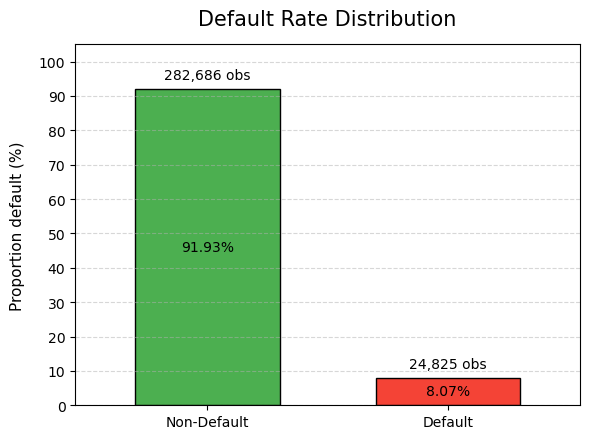

In [14]:
# Compute pct and count of default vs non-default
default_rate = home_credit['TARGET'].value_counts(normalize=True)*100
default_count = home_credit['TARGET'].value_counts()

# Plot barplot of default rate
fig = plt.figure(figsize=(6,4.5))
ax = default_rate.plot(kind='bar', color=['#4CAF50', '#F44336'], edgecolor='black', width=0.6)
plt.title('Default Rate Distribution', fontsize=15, pad = 14)
plt.xticks(ticks=[0,1], labels=['Non-Default', 'Default'], rotation=0)
plt.yticks(ticks=np.arange(0,105,10))
plt.ylabel('Proportion default (%)', fontsize=11, labelpad=10)
plt.ylim(0, 105)
plt.xlabel('', labelpad=10)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Count numbers on top of bars
for i, (rate, count) in enumerate(zip(default_rate, default_count)):
    ax.text(i, rate+2, f'{count:,} obs', ha='center', va='bottom', fontsize=10)

# Percentage inside the bars
for i,rate in enumerate(default_rate):
    ax.text(i,rate/2-2, f'{round(rate,2)}%', ha='center', va='bottom', fontsize=10) 

plt.tight_layout()
plt.show()

<u>Comment:</u>

The presence of an imbalanced class in the dataset (~8% default rate) raises attention for modeling choices, both in terms of algorithm selection and evaluation metrics. This is very common in risk assessment modeling, as the most costly events are often rare compared to the majority class. Additional care will be dedicated to train-validation-test splitting to maintain these proportions across all sets.

### <u>**4. Default Rate Segmentation by Category** </u>


#### <u>**4.1 Insights on NAME_CONTRACT_TYPE**</u>


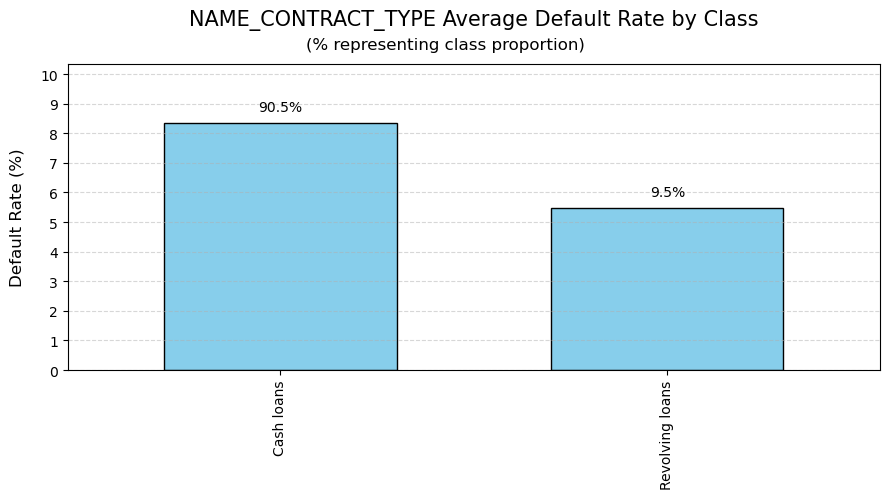

In [15]:
plot_categorical_default_rate(home_credit, 'NAME_CONTRACT_TYPE')

<u>Comment:</u>

The two loan types show a modest difference in default rates, with Cash loans (8.3%) versus Revolving loans (~5.5%). While this suggests some predictive signal, the difference is relatively small and the class distribution is highly imbalanced (90% vs 10%).

#### <u>**4.2 Insights on CODE_GENDER**</u>


In [16]:
home_credit.groupby('CODE_GENDER')['TARGET'].mean()*100

CODE_GENDER
F       6.999328
M      10.141920
XNA     0.000000
Name: TARGET, dtype: float64

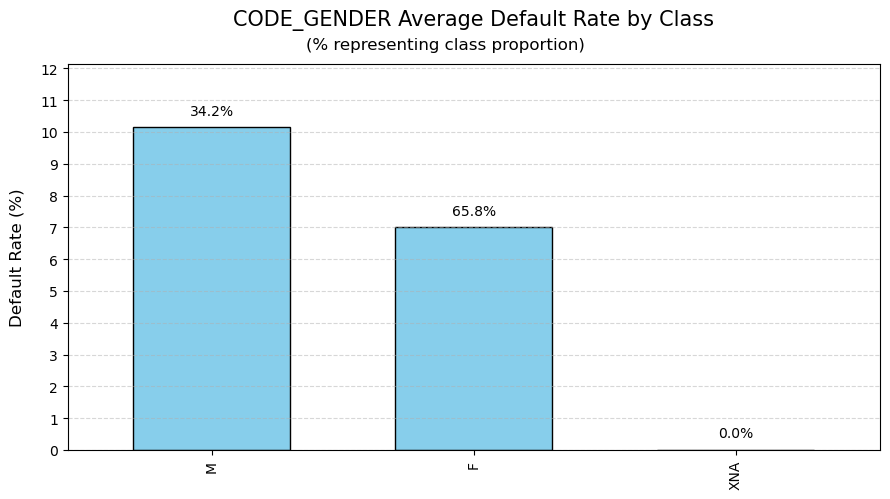

In [17]:
plot_categorical_default_rate(home_credit, 'CODE_GENDER')

In [18]:
home_credit[home_credit['CODE_GENDER']=='XNA'][['CODE_GENDER','TARGET']]

,CODE_GENDER,TARGET
SK_ID_CURR,,
319880,XNA,0
144669,XNA,0
141289,XNA,0
196708,XNA,0



<u>Comment:</u>


The gender distribution shows a modest default rate difference across classes, with male clients at 10.1% and female clients at 7%. The class distribution is relatively balanced with a slight skew toward female clients (66% vs 34%). Interestingly, four observations with missing gender values show no defaults, though given this minimal sample size, these will likely be dropped during preprocessing to maintain a clean binary variable for modeling.

#### <u>**4.3 Insights on NAME_EDUCATION_TYPE**</u>


In [ ]:
home_credit.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean()*100


NAME_EDUCATION_TYPE
Academic degree       1.829268
Higher education      5.355115
Incomplete higher     8.484966
Lower secondary      10.927673
Secondary             8.939929
Name: TARGET, dtype: float64

In [26]:
home_credit['NAME_EDUCATION_TYPE'].value_counts(normalize=True)

NAME_EDUCATION_TYPE
Secondary            0.710189
Higher education     0.243448
Incomplete higher    0.033420
Lower secondary      0.012409
Academic degree      0.000533
Name: proportion, dtype: float64

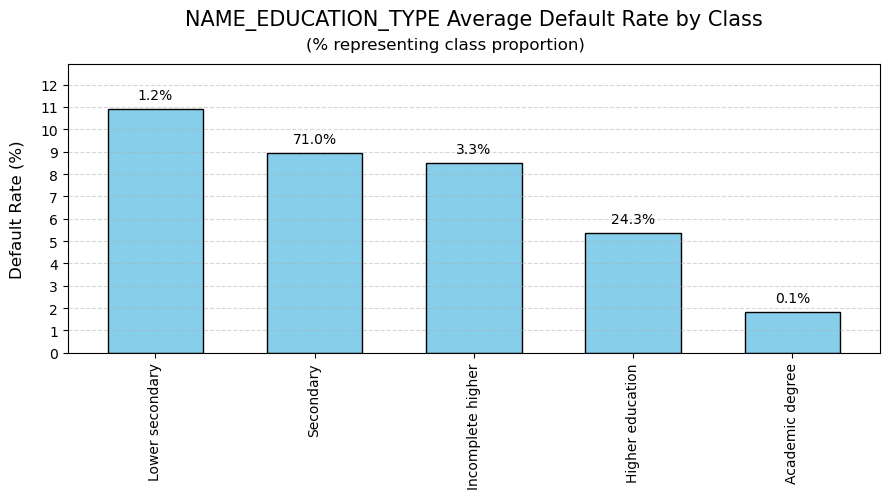

In [19]:
plot_categorical_default_rate(home_credit, 'NAME_EDUCATION_TYPE')

<u>Comment:</u>

A negative relationship between education level and default rate is observed, ranging from 10.9% (Lower secondary) to 1.8% (Academic degree). Given the small sample sizes at both extremes (Academic degree: 0.05%, Lower secondary: 1.2%) and the clustering of default rates, a three-tier grouping (High, Medium, Low education) will be explored during feature engineering to address sample stability concerns while preserving the key risk gradient.

#### <u>**4.4 Insights on NAME_TYPE_SUITE**</u>


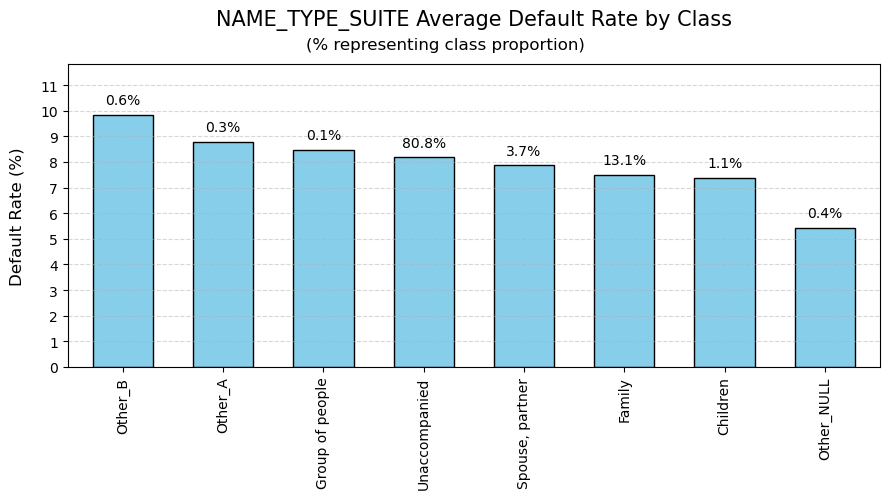

In [20]:
plot_categorical_default_rate(home_credit, 'NAME_TYPE_SUITE')


<u>Comment:</u>

The default rate across categories shows visible but marginal variation (~5-12%), clustering near the baseline of 8%, suggesting limited discriminatory power. Interestingly, missing values show the lowest default rate (~5%), which may indicate a distinct applicant profile suggesting a distinct category for the later encoding during the modelling.